# Оптимизация расходов ООО «Так закаляем сталь»

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

# Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. <br>

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Содержание

[1. Загрузка данных и первичный анализ](#section1)<br>
&nbsp;&nbsp;&nbsp;[1.1. Датасет 1: данные об электродах](#section1.1)<br>
&nbsp;&nbsp;&nbsp;[1.2. Датасет 2 и 3: данные о проволочных материалах (объём и время)](#section1.2)<br>
&nbsp;&nbsp;&nbsp;[1.3. Датасет 4 и 5: данные о подаче сыпучих материалов (объём и время)](#section1.3)<br>
&nbsp;&nbsp;&nbsp;[1.4. Датасет 6: данные о продувке сплава газом](#section1.4)<br>
&nbsp;&nbsp;&nbsp;[1.5. Датасет 7: результаты измерения температуры](#section1.5)<br>
[2. Характеристика процесса обработки стали](#section2)<br>
[3. Подготовка данных для обучения](#section3)<br>
&nbsp;&nbsp;&nbsp;[3.1. Формирование признаков](#section3.1)<br>
&nbsp;&nbsp;&nbsp;[3.2. Целевой признак](#section3.2)<br>
&nbsp;&nbsp;&nbsp;[3.3. Разделение наборов на обучающий и тестовый](#section3.3)<br>
[4. Обучение моделей](#section4)<br>
&nbsp;&nbsp;&nbsp;[4.1. Модель линейная регресиия](#section4.1)<br>
&nbsp;&nbsp;&nbsp;[4.2. Модель дерево решений](#section4.2)<br>
&nbsp;&nbsp;&nbsp;[4.3. Модель случайный лес](#section4.3)<br>
&nbsp;&nbsp;&nbsp;[4.4. Модель LightGBM](#section4.4)<br>
&nbsp;&nbsp;&nbsp;[4.5. Модель XGBoost](#section4.5)<br>
[5. Лучшая модель](#section5)<br>
&nbsp;&nbsp;&nbsp;[5.1. Анализ результатов](#section5.1)<br>
&nbsp;&nbsp;&nbsp;[5.2. Тестирование модели](#section5.2)<br>
&nbsp;&nbsp;&nbsp;[5.3. Сравнение с константой](#section5.3)<br>
[Отчет](#section6)<br>

In [1]:
# импортируем библиотеки и настройки
import pandas as pd
import numpy as np

import time
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

import lightgbm as lgb
import xgboost
from xgboost import plot_importance
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings('ignore')

<a id='section1'></a>
# 1. Загрузка данных и первичный анализ

<a id='section1.1'></a>
## 1.1. Датасет 1: данные об электродах

In [2]:
# загрузим датасет и распарсим даты, чтобы привести их к нужному формату
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv', parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
data_arc.info()
data_arc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null datetime64[ns]
Конец нагрева дугой     14876 non-null datetime64[ns]
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [3]:
# посмотрим за какой период у нас имеются данные
display('Начало нагрева дугой:', data_arc['Начало нагрева дугой'].sort_values().min())
display('Конец нагрева дугой:', data_arc['Конец нагрева дугой'].sort_values().max())

'Начало нагрева дугой:'

Timestamp('2019-05-03 11:02:14')

'Конец нагрева дугой:'

Timestamp('2019-09-01 04:36:08')

In [4]:
# взглянем на статистику активной и реактивной мощности
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


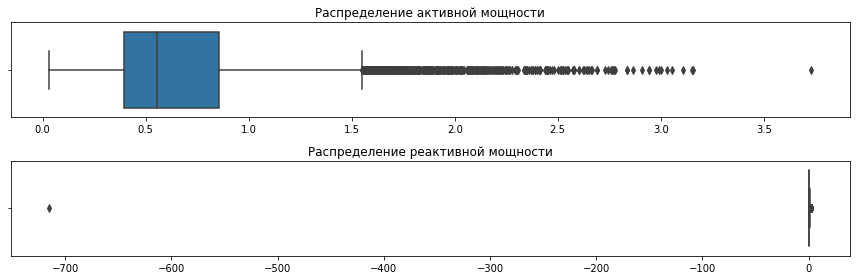

In [5]:
# также выведем оба распределения
f, axes = plt.subplots(2, 1, figsize=(12,4))
plt.subplot(211)
sns.boxplot(['Активная мощность'], data=data_arc, ax=plt.gca())
plt.title('Распределение активной мощности')
plt.subplot(212)
sns.boxplot(['Реактивная мощность'], data=data_arc, ax=plt.gca())
plt.title('Распределение реактивной мощности')
plt.tight_layout()

Как видно из графика, в реактивной мощности числится настолько большой выброс (минимум -715.5 против медианы 0.41), который не позволяет даже увидеть сам "ящик". Изучим его, а также максимальный выброс 3.73 в показателях активной мощности. 

In [6]:
# убедимся, что выброс единственный выбивается из общего ряда и заодно найдем индекс
data_arc['Реактивная мощность'].sort_values().head(5)

9780   -715.504924
5596      0.020806
2419      0.021154
4914      0.022485
4633      0.022983
Name: Реактивная мощность, dtype: float64

In [7]:
# посмотрим на все данные по индексу
data_arc.loc[9780]

key                                    2116
Начало нагрева дугой    2019-07-24 00:44:48
Конец нагрева дугой     2019-07-24 00:46:37
Активная мощность                  0.495782
Реактивная мощность                -715.505
Name: 9780, dtype: object

In [8]:
# другие показатели строки в норме, видимо это случайный баг, поэтому ее удалим
data_arc.drop([9780], inplace=True)

In [9]:
# теперь посмотрим на все максимальные значения активной мощности
data_arc['Активная мощность'].sort_values(ascending=False).head(5)

7799     3.731596
9226     3.156276
12424    3.150762
9870     3.107820
14200    3.052813
Name: Активная мощность, dtype: float64

In [10]:
# также проверим всю строку
data_arc.loc[7799]

key                                    1689
Начало нагрева дугой    2019-07-02 18:49:03
Конец нагрева дугой     2019-07-02 19:04:10
Активная мощность                    3.7316
Реактивная мощность                 2.67639
Name: 7799, dtype: object

In [11]:
# так как выброс единичен, то в данном случае тоже можем его удалить
data_arc.drop([7799], inplace=True)

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>Только одно измерение - поэтому, ТОЧНО не критично, ОК. Но если в принципе брать, то такая может быть ситуация: удалили измерение в партии. И если потом использовать как фактор суммарную мощность по партии, то уже будет искажение в данных...

In [12]:
# проверим на дубликаты
data_arc.duplicated().sum()

0

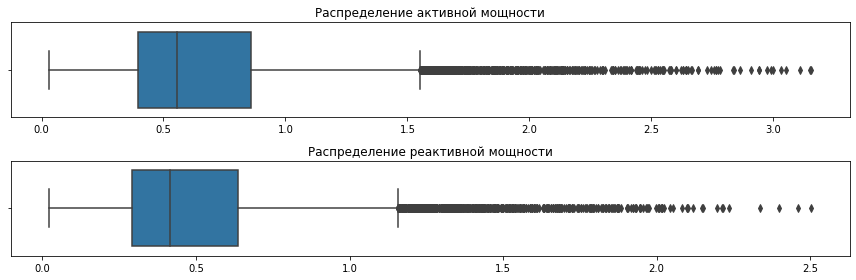

In [13]:
# удостоверимся, что теперь данные в порядке, повторно визуализировав оба распределения
f, axes = plt.subplots(2, 1, figsize=(12,4))
plt.subplot(211)
sns.boxplot(['Активная мощность'], data=data_arc, ax=plt.gca())
plt.title('Распределение активной мощности')
plt.subplot(212)
sns.boxplot(['Реактивная мощность'], data=data_arc, ax=plt.gca())
plt.title('Распределение реактивной мощности')
plt.tight_layout()

<a id='section1.2'></a>
## 1.2. Датасет 2 и 3:  данные о проволочных материалах (объём и время)

In [14]:
# загрузим датасет с объемами
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire.info()
data_wire.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# тоже проверим на дубли
data_wire.duplicated().sum()

0

In [16]:
# здесь пропуска означают, что материал не требовался, поэтому заполним их нулями
data_wire.fillna(0, inplace=True)
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3081 non-null float64
Wire 2    3081 non-null float64
Wire 3    3081 non-null float64
Wire 4    3081 non-null float64
Wire 5    3081 non-null float64
Wire 6    3081 non-null float64
Wire 7    3081 non-null float64
Wire 8    3081 non-null float64
Wire 9    3081 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [17]:
# загрузим датасет со временем
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv',
                            parse_dates=[1,2,3,4,5,6,7,8,9])
data_wire_time.info()
data_wire_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null datetime64[ns]
Wire 2    1079 non-null datetime64[ns]
Wire 3    63 non-null datetime64[ns]
Wire 4    14 non-null datetime64[ns]
Wire 5    1 non-null datetime64[ns]
Wire 6    73 non-null datetime64[ns]
Wire 7    11 non-null datetime64[ns]
Wire 8    19 non-null datetime64[ns]
Wire 9    29 non-null datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [18]:
# добавляли проволочные материалы с 3 мая 11:11 по 1 сентября 04:16
data_wire_time.tail(1)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3080,3241,2019-09-01 04:16:01,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [19]:
# тоже проверим на дубли
data_wire_time.duplicated().sum()

0

<a id='section1.3'></a>
## 1.3. Датасет 4 и 5: данные о подаче сыпучих материалов (объём и время)

In [20]:
# загрузим данные с объемом
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk.info()
data_bulk.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [21]:
# также проверим на дубли
data_bulk.duplicated().sum()

0

In [22]:
# так как материалы добавляли по мере необходимости, то значит остальные попросту не требовались
# поэтому заполним пропуски нулями
data_bulk.fillna(value=0, inplace=True)

In [23]:
# датасет 3 - данные о подаче сыпучих материалов (время)
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv', 
                             parse_dates = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
data_bulk_time.info()
data_bulk_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null datetime64[ns]
Bulk 2     22 non-null datetime64[ns]
Bulk 3     1298 non-null datetime64[ns]
Bulk 4     1014 non-null datetime64[ns]
Bulk 5     77 non-null datetime64[ns]
Bulk 6     576 non-null datetime64[ns]
Bulk 7     25 non-null datetime64[ns]
Bulk 8     1 non-null datetime64[ns]
Bulk 9     19 non-null datetime64[ns]
Bulk 10    176 non-null datetime64[ns]
Bulk 11    177 non-null datetime64[ns]
Bulk 12    2450 non-null datetime64[ns]
Bulk 13    18 non-null datetime64[ns]
Bulk 14    2806 non-null datetime64[ns]
Bulk 15    2248 non-null datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56


In [24]:
# первый материал добавили 3 мая 2019 в 11:21 и последний 1 сентября 2019 в 04:05
data_bulk_time.tail(1)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3128,3241,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-01 04:05:34,2019-09-01 04:05:34


In [25]:
# тоже проверим на дубли
data_bulk_time.duplicated().sum()

0

<a id='section1.4'></a>
## 1.4. Датасет 6: данные о продувке сплава газом

In [26]:
# загруэим датасет
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_gas.info()
data_gas.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [27]:
# проверим статистику
data_gas['Газ 1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

In [28]:
# тоже проверим на дубли
data_gas.duplicated().sum()

0

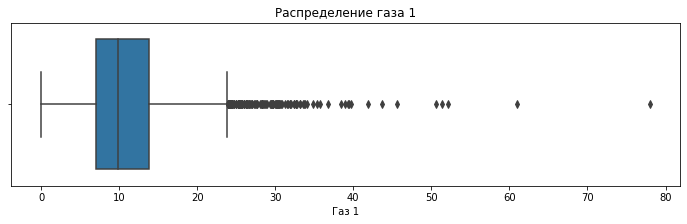

In [29]:
# визуализируем
plt.figure(figsize=(12,3))
sns.boxplot('Газ 1', data = data_gas)
plt.title('Распределение газа 1')
plt.show()

In [30]:
# сортируем значения в порядке убывания
data_gas[data_gas['Газ 1'] > 50].sort_values('Газ 1', ascending=False)

,key,Газ 1
319,322,77.995040
277,280,60.935689
2107,2110,52.142373
2567,2570,51.380229
116,117,50.581035


In [31]:
# значения выше 50 явно выбросы, поэтому их уберем
data_gas = data_gas[data_gas['Газ 1'] < 40]
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3231 entries, 0 to 3238
Data columns (total 2 columns):
key      3231 non-null int64
Газ 1    3231 non-null float64
dtypes: float64(1), int64(1)
memory usage: 75.7 KB


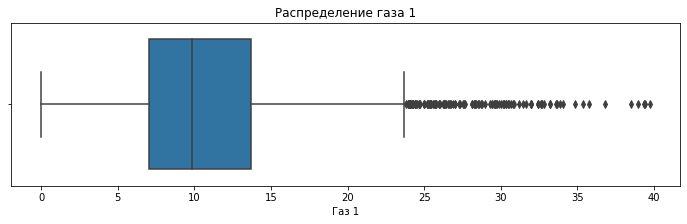

In [32]:
# проверим распределение
plt.figure(figsize=(12,3))
sns.boxplot('Газ 1', data = data_gas)
plt.title('Распределение газа 1')
plt.show()

<a id='section1.5'></a>
## 1.5. Датасет 7: результаты измерения температуры

In [33]:
# загрузим последний датасет с температурой
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv', parse_dates=['Время замера'])
data_temp.info()
data_temp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null datetime64[ns]
Температура     13006 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [34]:
# тоже проверим на дубли
data_temp.duplicated().sum()

0

In [35]:
# теперь осмотрим, что за пропуски
data_temp[data_temp['Температура'].isnull()]

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
...,...,...,...
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


Видим, что это партии начиная с 2 500 по 3 241 - рекомендуем изучить причины пропусков, так как это практически 700 кейсов.

In [36]:
# проверим нет ли пропусков в финальных замерах, то есть в нашем целовом признаке
last_temp = data_temp.groupby(['key'])['Температура'].agg({'Время замера' : 'max'}).reset_index()
last_temp.rename(columns = {'Время замера' : 'Последняя_температура'}, inplace=True)

last_temp['Последняя_температура'].value_counts(dropna=False)

1595.0    105
1594.0    101
1593.0     98
1598.0     89
1597.0     89
         ... 
1542.0      1
1669.0      1
1678.0      1
1659.0      1
1554.0      1
Name: Последняя_температура, Length: 147, dtype: int64

In [288]:
# удалим пропущенные значения, тк эту информацию не восстановить
data_temp.dropna(inplace=True)
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 3 columns):
key             13006 non-null int64
Время замера    13006 non-null datetime64[ns]
Температура     13006 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 406.4 KB


In [289]:
# посмотрим по сколько раз измеряли партии
data_temp['key'].value_counts(ascending=True).head()

2867    1
2771    1
2779    1
2787    1
2795    1
Name: key, dtype: int64

In [290]:
# уберем партии, которые измерялись всего один раз и проверим, что операция прошла успешно
data_temp = data_temp[data_temp.duplicated(subset='key', keep=False)]

data_temp.info()
data_temp['key'].value_counts(ascending=True).head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12265 entries, 0 to 12266
Data columns (total 3 columns):
key             12265 non-null int64
Время замера    12265 non-null datetime64[ns]
Температура     12265 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 383.3 KB


2194    2
1713    2
1381    2
1415    2
951     2
1801    2
2456    2
1416    2
1590    2
2423    2
Name: key, dtype: int64

In [291]:
# посмотрим на статистику
data_temp['Температура'].describe()

count    12265.000000
mean      1591.998859
std         20.834479
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64

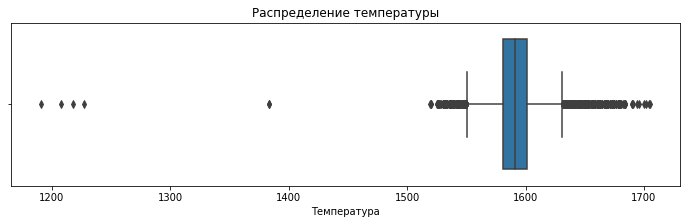

In [292]:
# визуализируем
plt.figure(figsize=(12,3))
sns.boxplot('Температура', data = data_temp)
plt.title('Распределение температуры')
plt.show()

In [293]:
# почистим таблицу от выбросов
data_temp = data_temp[(data_temp['Температура'] > 1525) & (data_temp['Температура'] < 1675)]
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12217 entries, 0 to 12266
Data columns (total 3 columns):
key             12217 non-null int64
Время замера    12217 non-null datetime64[ns]
Температура     12217 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 381.8 KB


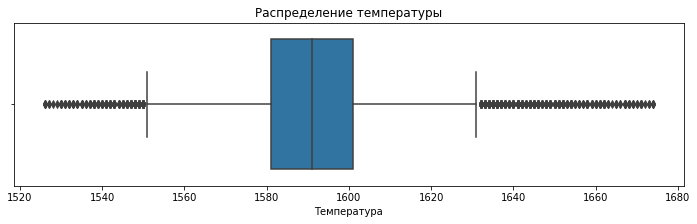

In [296]:
# проверим, что теперь данные в порядке
plt.figure(figsize=(12,3))
sns.boxplot('Температура', data = data_temp)
plt.title('Распределение температуры')
plt.show()

In [297]:
# анализируем также временной ряд, для этого оставим нужные колонки
# настроим индекс на дату и отсторируем
temp_eda = pd.read_csv('/datasets/final_steel/data_temp.csv', index_col=['Время замера'], parse_dates=['Время замера'])
temp_eda = temp_eda.drop(['key'], axis=1).sort_index()
temp_eda.info()
temp_eda.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15907 entries, 2019-05-03 11:16:18 to 2019-09-01 04:38:08
Data columns (total 1 columns):
Температура    13006 non-null float64
dtypes: float64(1)
memory usage: 248.5 KB


,Температура
Время замера,
2019-05-03 11:16:18,1571.0
2019-05-03 11:25:53,1604.0
2019-05-03 11:29:11,1618.0
2019-05-03 11:30:01,1601.0
2019-05-03 11:30:39,1613.0


In [298]:
# проверим что дата и время упорядочены корректно
temp_eda.index.is_monotonic

True

In [299]:
# уберем пропуски - это данные, которые нельзя восстановить
temp_eda.dropna(inplace=True)
temp_eda.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13006 entries, 2019-05-03 11:16:18 to 2019-09-01 04:03:30
Data columns (total 1 columns):
Температура    13006 non-null float64
dtypes: float64(1)
memory usage: 203.2 KB


In [300]:
# ресемплируем и объеденим данные за каждый день
temp_eda = temp_eda.resample('1D').median()

In [301]:
# снова на всякий случай уберем пропуски
temp_eda.dropna(inplace=True)
temp_eda.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 119 entries, 2019-05-03 to 2019-09-01
Data columns (total 1 columns):
Температура    119 non-null float64
dtypes: float64(1)
memory usage: 1.9 KB


In [302]:
# посчитаем значение скользящего среднего
temp_eda['rolling_mean'] = temp_eda.rolling(10).mean()

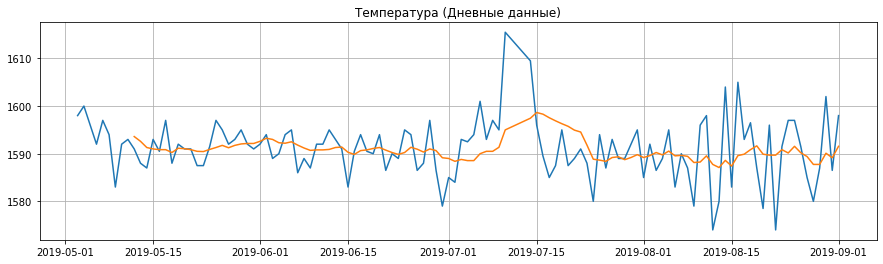

In [303]:
# построим график для оценки ситуации
plt.figure(figsize=(15, 4))
plt.plot(temp_eda)
plt.title('Температура (Дневные данные)')
plt.grid(True)
plt.show()

Всего было предоставлено 7 датасетов за 4 месяца: с 3 мая по 1 сентября 2019 год, результаты первичного анализа:
- __датасет 1: данные об электродах__ без пропусков, общий период примерно 4 месяца с 3 мая 11:02 по 1 сентября 04:36. Почистили по 1му выбросу в показателях активной и реактивной мощности, медианы 0.55 и 0.41 соответственно

- __датасеты 2 и 3: данные о проволочных материалах (объём и время)__, добавляли с 3 мая 11:11 по 1 сентября 04:16 наиболее часто использовавлись 1, 2 (1 079, 3 055 соответственно) и все остальные менее 75 раз. Пропуски заполнили нулями, тк материалы добавляли при необходимости

- __датасеты 4 и 5: данные о подаче 15 сыпучих материалов (объём и время)__ с 3 мая в 11:21 по 1 сентября в 04:05), из которых активнее всего требовались 12, 14, 15 (добавляли примерно в 2500 партий) и менее всего 2, 8, 13 (от 1 до 22). Здесь по той же логике заполнили пропуски нулями

- __датасет 6: данные о продувке газа без пропусков__ - на данном этапе можно увидеть, что партий осталось 3 239. Межквартильный размах примерно от 7 до 13.8, от выбросов почистили

- __датасет 7: результаты измерения температуры__ имеется большая прореха заполнения данных по температуре: всего замеров было сделано 15 907, а температура зафиксирована в 13 006 случаях начиная с 6 августа, выбросы ниже 1 500 градусов почистили. Анализ временного ряда показал, большой пик данных в первой половине Июля, в осталное время скользящее среднее практически на одном уровне, увеличивается только колебания в Августе.

<a id='section2'></a>
# 2. Характеристика процесса обработки стали

In [304]:
# вычислим длительность времени между замерами температуры
# для этого сгруппируем данные по номеру партии и найдем первое, последнее время
data_temp2 = data_temp.groupby(['key']).agg({'Время замера' : ['min', 'max']}).reset_index()
data_temp2.columns = ['key', 'Первое время замера', 'Последнее время замера']

data_temp2.head()

,key,Первое время замера,Последнее время замера
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01


In [305]:
# теперь можем посчитать длительность, на протяжении которого замеряли температуру
# оставим в датасете номер партии и полученный признак
data_temp2['full_time'] = data_temp2['Последнее время замера'] - data_temp2['Первое время замера']
data_temp2.drop(['Первое время замера', 'Последнее время замера'], axis=1, inplace=True)

data_temp2.head()

,key,full_time
0,1,00:14:21
1,2,00:21:45
2,3,00:21:40
3,4,00:06:28
4,5,00:12:42


In [306]:
# также отберем первые замеры температуры
first_temp = data_temp.groupby(['key'])['Температура'].agg({'Время замера' : 'first'}).reset_index()
first_temp.rename(columns={'Время замера': 'first_temp'}, inplace=True)
first_temp.head()

,key,first_temp
0,1,1571.0
1,2,1581.0
2,3,1596.0
3,4,1601.0
4,5,1576.0


In [307]:
# объединим полное время замера и первую измеренную температуру по каждой партии
data_temp2 = data_temp2.merge(first_temp, on='key')
data_temp2.head()

,key,full_time,first_temp
0,1,00:14:21,1571.0
1,2,00:21:45,1581.0
2,3,00:21:40,1596.0
3,4,00:06:28,1601.0
4,5,00:12:42,1576.0


In [308]:
# для каждой партии посчитатаем суммарную мощность и длительность нагрева дугой
data_arc2 = data_arc.copy()

data_arc2['arc_time'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']
data_arc2['power_sum'] = data_arc2['Активная мощность'] ** 2 + data_arc2['Реактивная мощность'] ** 2

data_arc2 = data_arc2.groupby(['key']).agg({'power_sum':'sum', 'arc_time':'sum', 
                                            'Начало нагрева дугой':'count'}).reset_index()

data_arc2.rename(columns = {'Начало нагрева дугой' : 'arc_starts'}, inplace=True)

data_arc2.head()

,key,power_sum,arc_time,arc_starts
0,1,7.681743,00:18:18,5
1,2,4.035983,00:13:31,4
2,3,2.381139,00:10:55,5
3,4,4.108330,00:12:21,4
4,5,5.580203,00:14:29,4


In [309]:
# объедним полученные таблицы по номеру партии
data_by_key = pd.merge(data_arc2, data_temp2, on='key', how='outer')

data_by_key.info()
data_by_key.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
key           3214 non-null int64
power_sum     3214 non-null float64
arc_time      3214 non-null timedelta64[ns]
arc_starts    3214 non-null int64
full_time     2475 non-null timedelta64[ns]
first_temp    2475 non-null float64
dtypes: float64(2), int64(2), timedelta64[ns](2)
memory usage: 175.8 KB


,key,power_sum,arc_time,arc_starts,full_time,first_temp
0,1,7.681743,00:18:18,5,00:14:21,1571.0
1,2,4.035983,00:13:31,4,00:21:45,1581.0
2,3,2.381139,00:10:55,5,00:21:40,1596.0
3,4,4.108330,00:12:21,4,00:06:28,1601.0
4,5,5.580203,00:14:29,4,00:12:42,1576.0


In [310]:
# уберем пропуски и посмотрим на статистику всех полученных столбцов
data_by_key.loc[:, 'power_sum': 'first_temp'].describe()

,power_sum,arc_time,arc_starts,full_time,first_temp
count,3214.000000,3214,3214.000000,2475,2475.000000
mean,4.452529,0 days 00:13:14.262912,4.627878,0 days 00:30:49.829494,1589.061010
std,3.307311,0 days 00:05:29.984587,1.606955,0 days 00:21:43.676846,24.787796
min,0.066377,0 days 00:00:57,1.000000,0 days 00:03:54,1526.000000
25%,2.097863,0 days 00:09:31,4.000000,0 days 00:19:36.500000,1572.000000
50%,3.735125,0 days 00:12:50,4.000000,0 days 00:26:28,1588.000000
75%,5.848349,0 days 00:16:23,6.000000,0 days 00:37:41,1605.000000
max,33.984714,0 days 00:54:42,16.000000,0 days 06:32:17,1673.000000


Анализировали характеристики по каждый партии и сформировали их в качестве признаков:
- в среднем химический состав корректируется в течение получаса
- половина из которого отводится на нагревание стали графитовыми электродами
- проходящих, как правильно, в течение 4-5 запусков нагрева
- приблизительная пропорция активной мощности к реактивной 1,78 : 1
- суммарная мощность в среднем для каждго случая нагревания примерно равна 4

<a id='section3'></a>
## 3. Подготовка данных для обучения


<a id='section3.1'></a>
## 3.1. Формирование признаков

In [311]:
# посчитаем и добавим сумму всех сыпучих и проволочных материалов для каждой партии
data_bulk['bulk_sum'] = (data_bulk.loc[:, 'Bulk 1' : 'Bulk 15']).sum(axis=1)
data_wire['wire_sum'] = (data_wire.loc[:, 'Wire 1' : 'Wire 9']).sum(axis=1)

In [312]:
# переведем время в секунды для использования в качестве признаков
data_by_key['full_time'] = data_by_key['full_time'].dt.seconds
data_by_key['arc_time'] = data_by_key['arc_time'].dt.seconds

In [313]:
# объединим для начала датасеты с данными о подаче материалов
materials = pd.merge(data_bulk, data_wire, on='key', how='outer')

materials.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,wire_sum
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


In [314]:
# отдельно объеденим данные по партиям и датасет с газом
features = pd.merge(data_by_key, data_gas, on='key')
features.dropna(inplace=True)
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 2465
Data columns (total 7 columns):
key           2466 non-null int64
power_sum     2466 non-null float64
arc_time      2466 non-null int64
arc_starts    2466 non-null int64
full_time     2466 non-null float64
first_temp    2466 non-null float64
Газ 1         2466 non-null float64
dtypes: float64(4), int64(3)
memory usage: 154.1 KB


In [315]:
# соединим результаты двух последних шагов и полного списка признаков
features = pd.merge(features, materials, on='key')

features.info()
features.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2439 entries, 0 to 2438
Data columns (total 33 columns):
key           2439 non-null int64
power_sum     2439 non-null float64
arc_time      2439 non-null int64
arc_starts    2439 non-null int64
full_time     2439 non-null float64
first_temp    2439 non-null float64
Газ 1         2439 non-null float64
Bulk 1        2398 non-null float64
Bulk 2        2398 non-null float64
Bulk 3        2398 non-null float64
Bulk 4        2398 non-null float64
Bulk 5        2398 non-null float64
Bulk 6        2398 non-null float64
Bulk 7        2398 non-null float64
Bulk 8        2398 non-null float64
Bulk 9        2398 non-null float64
Bulk 10       2398 non-null float64
Bulk 11       2398 non-null float64
Bulk 12       2398 non-null float64
Bulk 13       2398 non-null float64
Bulk 14       2398 non-null float64
Bulk 15       2398 non-null float64
bulk_sum      2398 non-null float64
Wire 1        2363 non-null float64
Wire 2        2363 non-null float64

,key,power_sum,arc_time,arc_starts,full_time,first_temp,Газ 1,Bulk 1,Bulk 2,Bulk 3,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,wire_sum
0,1,7.681743,1098,5,861.0,1571.0,29.749986,0.0,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,4.035983,811,4,1305.0,1581.0,12.555561,0.0,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,2.381139,655,5,1300.0,1596.0,28.554793,0.0,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,4.108330,741,4,388.0,1601.0,18.841219,0.0,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,5,5.580203,869,4,762.0,1576.0,5.413692,0.0,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


In [316]:
# восполним нулями данные по материалам
features.fillna(value=0, inplace=True)

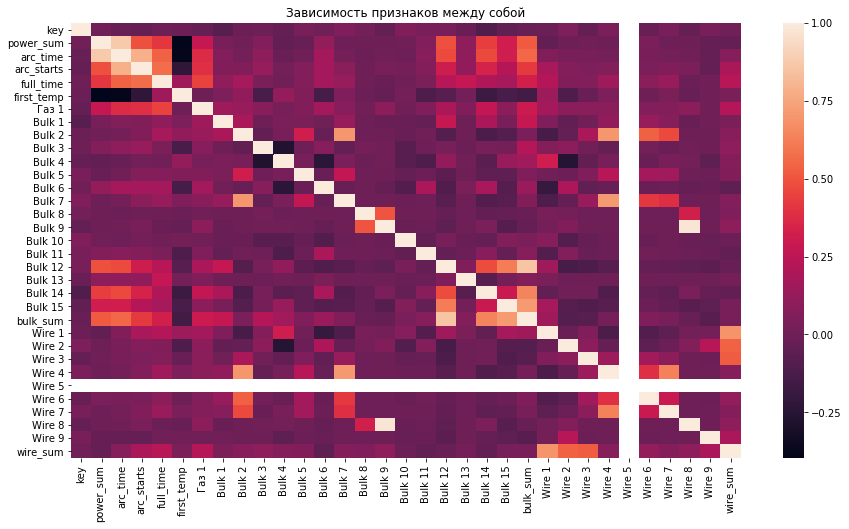

In [317]:
# анализируем коллинеарность признаков между собой
# построим тепловую матрицу
corr = (features).corr()
plt.figure(figsize=(15,8))
plt.title('Зависимость признаков между собой')
sns.heatmap(corr)
plt.show()

In [318]:
# найдем признаки, у которых зависимость ниже 0.8
cols = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.8:
            if cols[j]:
                cols[j] = False

features.columns[cols]

Index(['key', 'power_sum', 'arc_starts', 'full_time', 'first_temp', 'Газ 1',
       'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7',
       'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13',
       'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5',
       'Wire 6', 'Wire 7', 'Wire 9', 'wire_sum'],
      dtype='object')

In [319]:
# оставим полученные признаки
selected_cols = features.columns[cols]
features = features[selected_cols]

In [320]:
# масштабируем полученные признаки, кроме номера партии
features_scaled = pd.DataFrame(StandardScaler().fit_transform(features.loc[:, 'power_sum':'wire_sum']))
features_scaled.columns = ['power_sum', 'arc_starts', 'full_time', 'first_temp', 'gas',
                           'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',
                           'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13',
                           'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5',
                           'wire_6', 'wire_7', 'wire_9', 'wire_sum']

features_scaled.columns

Index(['power_sum', 'arc_starts', 'full_time', 'first_temp', 'gas', 'bulk_1',
       'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8',
       'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14',
       'bulk_15', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_9', 'wire_sum'],
      dtype='object')

<a id='section3.2'></a>
## 3.2. Целевой признак

In [321]:
# создадим новый датасет с целевым признаком - последней измеренной температурой
# для этого сгруппируем по номеру партии и отфильтруем по последнему замеру
target = data_temp.groupby(['key'])['Температура'].agg({'Время замера':'last'}).reset_index()
target.rename(columns={'Время замера':'Температура'}, inplace=True)
target.info()
target.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 2 columns):
key            2475 non-null int64
Температура    2475 non-null float64
dtypes: float64(1), int64(1)
memory usage: 38.8 KB


,key,Температура
0,1,1613.0
1,2,1602.0
2,3,1599.0
3,4,1625.0
4,5,1602.0


In [322]:
# оставим только те партии, которые присутствуют в признаках
target = target.query('key in @features.key')
target = target[['Температура']]
target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2439 entries, 0 to 2474
Data columns (total 1 columns):
Температура    2439 non-null float64
dtypes: float64(1)
memory usage: 38.1 KB


<a id='section3.3'></a>
## 3.3. Разделение выборок на обучающий и тестовый

In [323]:
# разобьем выборки в пропорции 80:20
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, 
                                                    test_size=0.1, random_state=42)

In [324]:
# проверим размеры получившихся данных
print('Размер обучающей выборки', X_train.shape, y_train.shape)
print('Размер тестовой выборки', X_test.shape, y_test.shape)

Размер обучающей выборки (2195, 29) (2195, 1)
Размер тестовой выборки (244, 29) (244, 1)


Подготовили данные:
- Добавили признаки, сформированные в прошлом шаге, в т.ч. первый замер температуры, сумму материалов, объединили все признаки, убрали зависимые и масштабировали
- Сформировали целевой признак - последний замер температуру и оставили значения только тех партий, по которым имеются признаки
- Разделили и получили обучающий, тестовый наборы в пропорции 90 к 10

<a id='section4'></a>
## 4. Обучение моделей

<a id='section4.1'></a>
## 4.1. Модель линейная регрессия

In [325]:
# результаты кросс валидации линейной регресии 6.77
reg = LinearRegression()

time_start_reg = time.time()
cv_reg = -cross_val_score(reg, X_train, y_train, scoring='neg_mean_absolute_error', cv=5).mean()
time_finish_reg = time.time()

time_reg = time_finish_reg - time_start_reg 

print('Время выполнения: {:.2f}'. format(time_reg))
print('Средний MAE: {:.2f}'.format(cv_reg))

Время выполнения: 1.20
Средний MAE: 6.77


<a id='section4.2'></a>
## 4.2. Модель дерево решений

In [326]:
# подберем гиперпараметры для модели
dtr = DecisionTreeRegressor(random_state=42, criterion='mae')

random_grid = {"max_leaf_nodes": [5, 20, 100], 
               "max_depth": (list(range(1, 20))), 
               "min_samples_split": [2, 3, 4, 10, 20, 40], 
               "min_samples_leaf": list(range(1, 20))}

dtr_random = RandomizedSearchCV(estimator = dtr, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=1, n_jobs = -1)

dtr_random.fit(X_train, y_train)
dtr_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.4min finished


{'min_samples_split': 4,
 'min_samples_leaf': 9,
 'max_leaf_nodes': 100,
 'max_depth': 18}

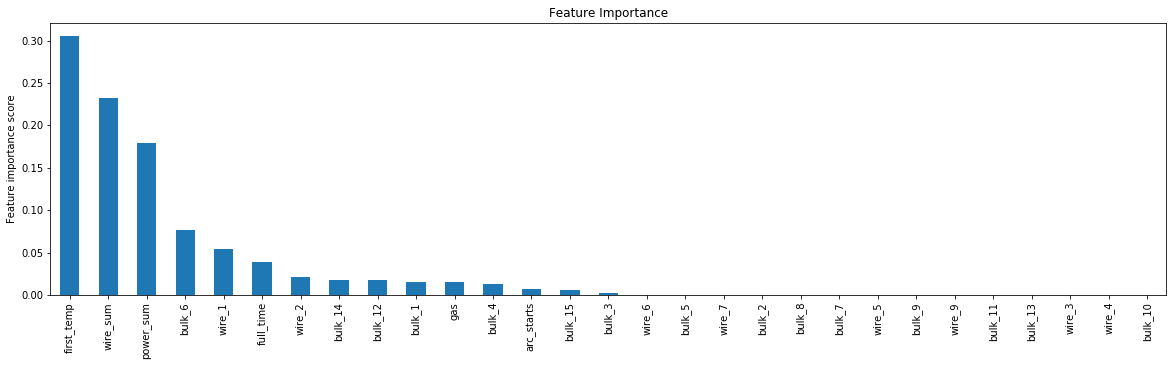

In [327]:
# выведем график важности признаков
predictors = [x for x in X_train.columns]
feat_imp = pd.Series(dtr_random.best_estimator_.feature_importances_, 
                     predictors).sort_values(ascending=False)
plt.rcParams['figure.figsize'] = 20,5
feat_imp.plot(kind='bar', title='Feature Importance')
plt.ylabel('Feature importance score')
plt.show()

In [328]:
# модель с лучшими гиперпараметрами
best_grid = {'min_samples_split': 3,
             'min_samples_leaf': 19,
             'max_leaf_nodes': 100,
             'max_depth': 11}

dtr_best = DecisionTreeRegressor(random_state=42, criterion='mae', **best_grid)

time_start_dtr = time.time()
cv_dtr = -cross_val_score(dtr_best, X_train, y_train, scoring='neg_mean_absolute_error', cv=5).mean()
time_finish_dtr = time.time()

time_dtr = time_finish_dtr - time_start_dtr

print('Время выполнения: {:.2f}'. format(time_dtr))
print('Средний MAE: {:.2f}'.format(cv_dtr))

Время выполнения: 2.29
Средний MAE: 7.07


<a id='section4.2'></a>
## 4.2. Модель случайный лес

In [ ]:
# подберем лучшие гиперпараметры опираясь на нашу метрику MAE
rf = RandomForestRegressor()

random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'min_samples_split': [2, 5, 10, 15],
               'min_samples_leaf': [1, 2, 5],
               'bootstrap': [True, False]}

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=1, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


In [330]:
# лучшая модель
rf_best = RandomForestRegressor(n_estimators=1400, min_samples_split=10, min_samples_leaf=1, 
                           max_features='auto', max_depth=40, bootstrap=True, random_state = 42)

time_start_rf = time.time()
cv_rf = -cross_val_score(rf_best, X_train, y_train, scoring='neg_mean_absolute_error', cv=3).mean()
time_finish_rf = time.time()

time_rf = time_finish_rf - time_start_rf

print('Время выполнения: {:.2f}'.format(time_rf))
print('Средний MAE: {:.2f}'.format(cv_rf))

Время выполнения: 57.05
Средний MAE: 6.25


<a id='section4.3'></a>
## 4.3. Модель LightGBM

In [353]:
# построим базовую модель
gbm_base = lgb.LGBMRegressor()

time_start_gbm_base = time.time()
cv_gbm_base = -cross_val_score(gbm_best, X_train, y_train, scoring='neg_mean_absolute_error', cv=3).mean()
time_finish_gbm_base = time.time()

time_gbm_base = time_finish_gbm_base - time_start_gbm_base

print('Время выполнения: {:.2f}'. format(time_gbm_base))
print('Средний MAE: {:.2f}'.format(cv_gbm_base))

Время выполнения: 0.55
Средний MAE: 6.02


In [332]:
# теперь также подтюним гиперпараметры
gbm = lgb.LGBMRegressor()

random_grid = {'learning_rate': [0.01, 0.05],
              'num_leaves': [20, 90, 150],
              'max_depth' : [5, 8, 20, 25],
              'random_state' : [42], 
              'colsample_bytree' : [0.5, 0.7, 0.9],
              'subsample' : [0.5, 0.7],
              'min_split_gain' : [0.01],
              'min_data_in_leaf': [10, 20, 40],
              'metric':['mae']}         
                
gbm_random = RandomizedSearchCV(gbm, random_grid, cv = 3, n_jobs=-1, n_iter=100)
gbm_random.fit(X_train, y_train)
gbm_random.best_params_

{'subsample': 0.7,
 'random_state': 42,
 'num_leaves': 20,
 'min_split_gain': 0.01,
 'min_data_in_leaf': 10,
 'metric': 'mae',
 'max_depth': 8,
 'learning_rate': 0.05,
 'colsample_bytree': 0.7}

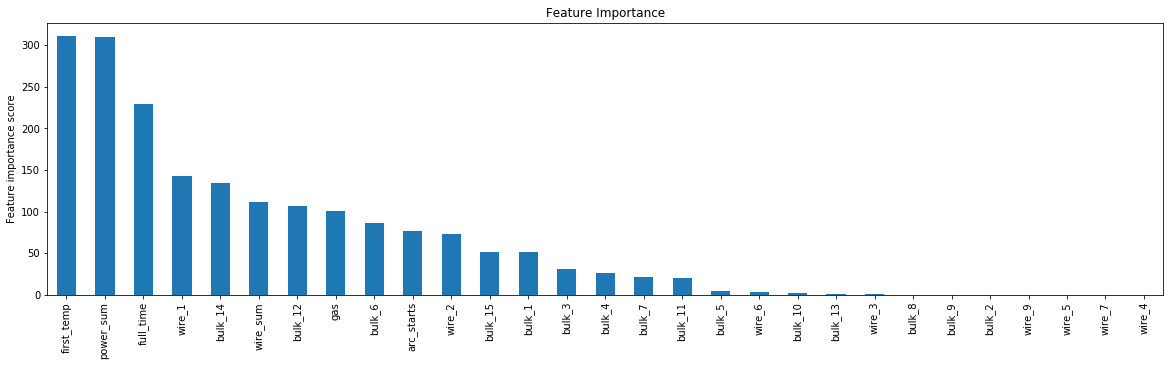

In [333]:
# проверим какие факторы важны для данной модели
predictors = [x for x in X_train.columns]
feat_imp = pd.Series(gbm_random.best_estimator_.feature_importances_, 
                     predictors).sort_values(ascending=False)
plt.rcParams['figure.figsize'] = 20,5
feat_imp.plot(kind='bar', title='Feature Importance')
plt.ylabel('Feature importance score')
plt.show()

In [347]:
# результаты модели с лучшими гиперпарарметрами
best_grid = {'subsample': 0.7,
             'random_state': 42,
             'num_leaves': 20,
             'min_split_gain': 0.01,
             'min_data_in_leaf': 10,
             'metric': 'mae',
             'max_depth': 8,
             'learning_rate': 0.05,
             'colsample_bytree': 0.7}

gbm_best = lgb.LGBMRegressor(**best_grid)

time_start_gbm = time.time()
cv_gbm = -cross_val_score(gbm_best, X_train, y_train, scoring='neg_mean_absolute_error', cv=3).mean()
time_finish_gbm = time.time()

time_gbm = time_finish_gbm - time_start_gbm

print('Время выполнения: {:.2f}'. format(time_gbm))
print('Средний MAE: {:.2f}'.format(cv_gbm))

Время выполнения: 2.56
Средний MAE: 6.02


<a id='section4.4'></a>
## 4.4. Модель XGBoost

In [351]:
%%time
# усредненный результат кросс валидации базовой модели
xgb = xgboost.XGBRegressor()
cv_xgb_base = -cross_val_score(xgb, X_train, y_train, scoring='neg_mean_absolute_error', cv=5).mean()
print('Средний MAE: {:.2f}'.format(cv_xgb_base))

[13:31:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Средний MAE: 5.90
CPU times: user 1.3 s, sys: 7.84 ms, total: 1.31 s
Wall time: 1.32 s


In [337]:
# подберем гиперпараметры для модели
xgb = xgboost.XGBRegressor(eval_metric='mae', silent=True, nthread=4)

random_grid = {'min_child_weight': [1, 5, 7, 10],
               'learning_rate': [0.001, 0.01, 0.1],
               'n_estimators':[600, 1000, 5000],
               'gamma': [0, 0.03, 0.1, 0.5],
               'subsample': [0.6, 0.8, 1.0],
               'colsample_bytree': [0.4, 0.6, 0.8, 1.0],
               'max_depth': [3, 4, 5],
               'num_boost_round': [10, 25, 50],
               'eta': [0.05, 0.1, 0.3]}

xgb_random = RandomizedSearchCV(xgb, random_grid, n_jobs=1, cv=3, random_state=42)
xgb_random.fit(X_train, y_train)
xgb_random.best_params_

{'subsample': 1.0,
 'num_boost_round': 10,
 'n_estimators': 1000,
 'min_child_weight': 5,
 'max_depth': 5,
 'learning_rate': 0.01,
 'gamma': 0.1,
 'eta': 0.3,
 'colsample_bytree': 0.6}

In [338]:
# результат лучшей модели
best_grid = {'subsample': 1.0,
             'num_boost_round': 10,
             'n_estimators': 1000,
             'min_child_weight': 5,
             'max_depth': 5,
             'learning_rate': 0.01,
             'gamma': 0.1,
             'eta': 0.3,
             'colsample_bytree': 0.6}

xgb_best = xgboost.XGBRegressor(eval_metric='mae', silent=True, nthread=4, **best_grid)

time_start_xgb = time.time()
cv_xgb = -cross_val_score(xgb_best, X_train, y_train, scoring='neg_mean_absolute_error', cv=3).mean()
time_finish_xgb  = time.time()

time_xgb  = time_finish_xgb  - time_start_xgb 

print('Время выполнения: {:.2f}'. format(time_xgb))
print('Средний MAE: {:.2f}'.format(cv_xgb))

Время выполнения: 15.09
Средний MAE: 5.94


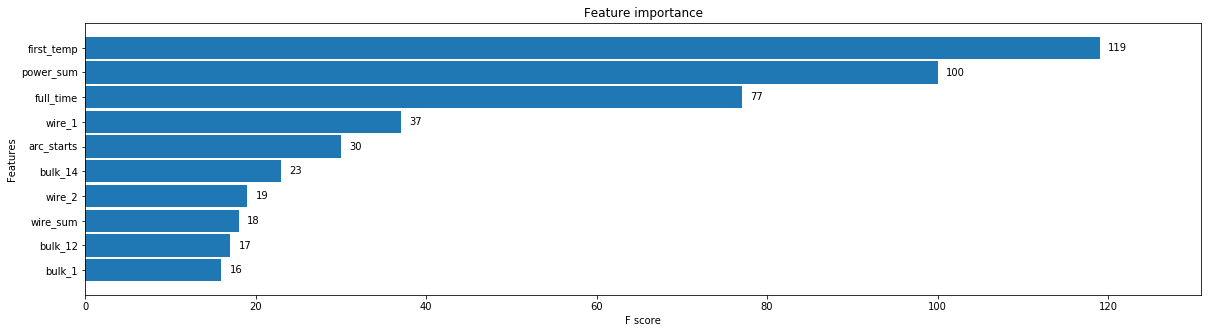

In [339]:
# посмотрим какие признаки повлияли больше всего
xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], 
        early_stopping_rounds=50, verbose=False)

_ = plot_importance(xgb, height=0.9, max_num_features=10, grid=False)

<a id='section5'></a>
## 5. Лучшая модель

<a id='section5.1'></a>
## 5.1. Анализ результатов

In [ ]:
# создадим таблицу с показателями всех моделей
cv_all = pd.DataFrame([['Линейная регрессия', cv_reg, time_reg],
                       ['Дерево решений', cv_dtr, time_dtr], 
                       ['Случайный лес', cv_rf, time_rf], 
                       ['LightGBM base', cv_gbm_base, time_gbm_base],
                       ['LightGBM', cv_gbm, time_gbm],
                       ['XGBoost', cv_xgb, time_xgb]], 
                      columns=['Модель', 'MAE', 'Время'])

cv_all = cv_all.sort_values(['MAE'])
cv_all

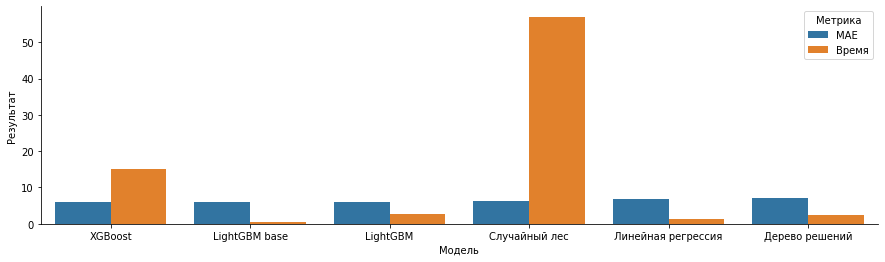

In [355]:
# визуализируем сравнение
cv_plot = pd.melt(cv_all, id_vars='Модель').rename(columns={'variable':'Метрика', 'value':'Результат'})
fig, ax1 = plt.subplots(figsize=(15, 4))
sns.barplot(x='Модель' , y='Результат', hue='Метрика', data=cv_plot, ax=ax1)
sns.despine(fig)

Сравнили результаты 5 моделей:
- Лучшие результаты у модели XGBoost MAE 5.94, но при модель довольно долго обучается 15.1 сек;
- Второй лидер LightGBM base с MAE 6.02 и с отличным результатом по длительности работы 0.5 сек - с учетом результатов по 2 важным метрикам и примем ее за лучшую модель;
- Самое длительное время обучения у модели Случайный лес - дольше 50 сек;
- Результаты остальных моделей примерно на одном уровне.

<a id='section5.2'></a>
## 5.2. Тестирование модели

In [344]:
# проверим как отработает лучшая модель на тестовом наборе данных
best_model = lgb.LGBMRegressor()
best_model.fit(X_train, y_train)
pred = best_model.predict(X_test)

mae = mean_absolute_error(pred, y_test)
print('MAE лучшей модели: {:.2f}'.format(mae))

MAE лучшей модели: 5.76


<a id='section5.3'></a>
## 5.3. Сравнение с константой

In [346]:
# проверим со стратегией модели по константной средней температурой
dummy = DummyRegressor(strategy="mean")
cv_dummy = -cross_val_score(dummy, X_train, y_train, scoring='neg_mean_absolute_error', cv=2).mean()
print('MAE константной модели: {:.2f}'.format(cv_dummy))

MAE константной модели: 9.46


<a id='section6'></a>
## Отчет

Перед нами стояла **задача оптимизации производственных расходов Металлургического комбината ООО «Так закаляем сталь» путем уменьшения потребления электроэнергии на этапе обработки стали**. В качестве вводных было предоставлено 7 файлов с данными по каждому этапу обработки за 4 месяца (с 3 мая по 1 сентября 2019 года), на основе которых строились модели, предсказывающую последний замер температуры стали. Качество модели оценивалась метрикой Mean Absolute Error (MAE).

**Первым делом провели первичный анализ, изучили аномалии и предобработали данные:**
* **датасет 1: данные об электродах**, содержит о начале/конце периода нагрева и показатели активной/реактивной мощности (большинство замеров в пределах до 0.55/0.41). Самый яркий выброс в значениях реактивной мощности -715.5, зафиксированный 2019-07-24 00:44-00:46;
* **датасеты 2 и 3: данные о подаче 9 проволочных материалах (объём и время)**, добавляли с 3 мая 11:11 по 1 сентября 04:16 наиболее часто требовались 1, 2 (1 079, 3 055 соответственно) и все остальные менее чем в 75 случаев;
* **датасеты 4 и 5: данные о подаче 15 сыпучих материалов (объём и время)** с 3 мая в 11:21 по 1 сентября в 04:05, из которых чаще всего добавлялись 12, 14, 15 (примерно в 2500 партий) и менее всего 2, 8, 13 (от 1 до 22);
* **датасет 6: данные о продувке газа** - на данном этапе можно увидеть, что партий всего 3 239. Большинство значений варьируются от 7 до 13.8; 
* **датасет 7: результаты измерения температуры** - имеется большая прореха в заполнении начиная с 6 августа до конца периода: всего замеров было сделано 15 907, а температура зафиксирована в 13 006 случаях. Данные не восстанавливаемые, поэтому их пришлось удалить, предварительно удостоверившись, что записи не являются последними замерами (тк это наш целевой признак). Также выявили ошибочные ~700 партий с единственными замерами, которые тоже отбросили. Анализ временного ряда показал большой пик градуса в первой половине Июля, а также увеличение колебаний в Августе в рамках от 1 575 до 1605 по сравнению с предыдущими месяцами (в среднем от 1 585 до 1 595). Рекомендуется подробнее изучать оба периода для понимания причин. 

**Далее составили характеристики по каждый партии и сформировали на их основе новые признаки, влияющие на электроэнергию:**
* в среднем химический состав корректируется в течение получаса (признак Длительность замера температуры)
* половина из которого отводится на нагревание стали графитовыми электродами (Время нагрева электродами)
* проходящих, как правильно, в течение 4-5 запусков нагрева (Количество запусков нагрева электродами)
* приблизительная пропорция активной мощности к реактивной 1,78 : 1 (Среднее соотношение потребления активной и реактивной мощности)
* в среднем для каждого случая нагревания примерно затрачивается 4 мощности (Суммарное потребление мощность)

**Затем приступили к подготовке наборов данных для обучения и тестирования:**
- Объединили признаки и добавили новые, сформированные в предыдущем шаге, в т.ч. Первый замер температуры, Сумму проволочных/ сыпучих материалов, убрали зависимые (коррелирующие более, чем 0.8)
- Сформировали целевой признак - последний замер температуру и оставили значения только тех партий, по которым имеются признаки
- Всего получили 30 признаков и 2 439 наблюдений. Разделили и получили обучающий, тестовый наборы в пропорции 90:10.

**Финальным шагом построили 5 моделей, анализировали результаты и определили лучшую модель:**
- Лучшие результаты у модели XGBoost MAE 5.94, но при модель довольно долго обучается 15.1 сек;
- Второй лидер LightGBM base с MAE 6.02 и с отличным результатом по длительности работы 0.5 сек - с учетом результатов по 2 важным метрикам и примем ее за лучшую модель;
- Самое длительное время обучения у модели Случайный лес и результаты остальных моделей примерно на одном уровне;
- MAE константной модели по среднему замеру температуры - 9.46

**Испытание лучшей модели LightGBM base на тестовых данных завершилось с результатом 5.76 - мы добились необходимого результата! 
Обращаем внимание и рекомендуем более подробно изучить периоды:** Июль - в первой половине месяца огромный скачок температуры до 1 615 (при медиане 1 590), Август и Сентябрь - много пропущенных замеров температуры (~20% от общего количества), начиная примерно с 10 Августа до конца периода колебание температуры увеличивается приблизительно в 3 раза (было 1 585 - 1 595/ стало 1 575 - 1605). Вполне вероятно это периоды самых высоких энергозатрат и при выявлении причин, возможно будет ввести профилактические мероприятия, также позволяющие оптимизировать расходы.

<a id='section100'></a>
[ВВЕРХ](#section99)<br>